In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
#using NearestNeighbors # Can't use KDtree in julia for posterior prediction

In [2]:
include("../../util.j")

colnorm (generic function with 1 method)

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
#using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
#using MCMCChains
#using PrettyTables

In [4]:
#using Pkg
#Pkg.add("NearestNeighborDescent");
#using NearestNeighborDescent

In [5]:
# Set the parameters for conjugate model #

N = 1200;   # sample size
n = 1000;  # observations number
q = 2; p = 2; 
Σ = [2 -1
     -1 1.5];
β = [1.0 -1.0
     -5.0 2.0];
ϕ1 = 6.0; ν1 = 0.5; # parameter for the independent F
α = 0.9;            # σ2 / (σ2 + τ2)

In [6]:
# Generate simulation data #

Random.seed!(123); #123 
coords = rand(2, N);                                          # random location over unit square 123
X = hcat(fill(1, (N,)), rand(N));                             # design matrix
D = pairwise(Euclidean(), coords, dims = 2);                  # distance matrix
ρ1 = exp.(-ϕ1 * D);                                           # covariance matrix
F = [rand(MvNormal(ρ1), 1) rand(MvNormal(ρ1), 1)];
UΣ = cholesky(Σ).U;
ω = F * UΣ; # latent process
Y = X * β + ω + transpose(rand(MvNormal(Σ * (1 / α - 1.0)), N));              # response matrix

In [7]:
# Split the data for training and testing #

ordx = sortperm(coords[1, :]);                                # sort order based on the first coordinates
X_ord = X[ordx, :]; Y_ord = Y[ordx, :]; ω_ord = ω[ordx, :];   # sorted data
ω_incp_obs = ω_ord + fill(1.0, (N, 1)) * transpose(β[1, :]);  # latent process + intercept
coords_ord = coords[:, ordx];
S = sample(1:N, n, replace = false, ordered = true);          # observed location index for 1st response
M = setdiff(1:N, S);                                          # index of missing data


In [8]:
# build neighbors #

m = 10;                                                       # number of nearest neighbor                       
NN = BuildNN(coords_ord[:, S], m, 1.0);                       # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:n);                            # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):n, inner = m), 1:n);  # the index of rows

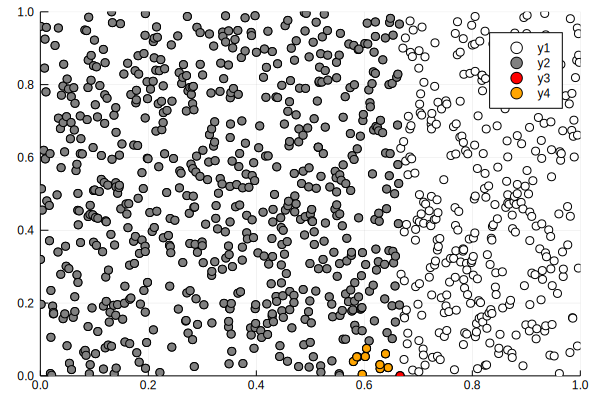

In [9]:
# check neighbors
index = 660
gr()
scatter(coords_ord[1, S], coords_ord[2, S], xlim = (0, 1), ylim = (0, 1), color = :white)
scatter!(coords_ord[1, S[1:index]], coords_ord[2, S[1:index]], color = :grey)
scatter!(coords_ord[1, S[index:index]], coords_ord[2, S[index:index]], color = :red)
scatter!(coords_ord[1, S[NN.nnIndx[NN.nnIndxLU[index]:(NN.nnIndxLU[index + 1] - 1)]]], 
    coords_ord[2, S[NN.nnIndx[NN.nnIndxLU[index]:(NN.nnIndxLU[index + 1] - 1)]]], color = :orange)

In [10]:
@save "sim1data.jld" 

In [11]:
using RCall
R"""
print(R.Version())
"""

$platform
[1] "x86_64-pc-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "3"

$minor
[1] "4.4"

$year
[1] "2018"

$month
[1] "03"

$day
[1] "15"

$`svn rev`
[1] "74408"

$language
[1] "R"

$version.string
[1] "R version 3.4.4 (2018-03-15)"

$nickname
[1] "Someone to Lean On"



RObject{VecSxp}
$platform
[1] "x86_64-pc-linux-gnu"

$arch
[1] "x86_64"

$os
[1] "linux-gnu"

$system
[1] "x86_64, linux-gnu"

$status
[1] ""

$major
[1] "3"

$minor
[1] "4.4"

$year
[1] "2018"

$month
[1] "03"

$day
[1] "15"

$`svn rev`
[1] "74408"

$language
[1] "R"

$version.string
[1] "R version 3.4.4 (2018-03-15)"

$nickname
[1] "Someone to Lean On"

